<a href="https://colab.research.google.com/github/pradyotqc/Atoms_molecules01/blob/main/QKD_Atoms_molecule_11_12_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q qiskit
! pip install -q qiskit-aer
! pip install -q qiskit-algorithms
! pip install -q qiskit-nature
! pip install -q qiskit-nature-pyscf # install the pyscf library
! pip install -q qiskit-ibm-runtime
# print(qiskit.__version__)
# print(qiskit_aer.__version__)
# print(qiskit_algorithms.__version__)
# print(qiskit_nature.__version__)
# print(qiskit_nature_pyscf.__version__)
# print(qiskit_ibm_runtime.__version__)


In [121]:
import qiskit_nature
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime
import qiskit_nature_pyscf
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer import  AerSimulator
# from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper

# Analysis of H2 molecule :

In [122]:
# Define the He2 molecule
molecule = MoleculeInfo(
    symbols=["H", "H"],
    coords=([0.0, 0.0, 0.0], [0.0, 0.0, 0.7]),  # Approximate bond distance for He2
    multiplicity=1,  # Singlet state
    charge=0
)

# Set up the PySCF driver
driver = PySCFDriver.from_molecule(
    molecule=molecule,
    basis="sto3g"
)

# Run the electronic structure calculation
electronic_structure_problem = driver.run()

# Apply FreezeCoreTransformer to simplify the problem
transformer = FreezeCoreTransformer()
electronic_structure_problem = transformer.transform(electronic_structure_problem)

# Extract the second quantized Hamiltonian
electronic_energy = electronic_structure_problem.hamiltonian

# Map to qubit Hamiltonian using Jordan-Wigner transformation
mapper = JordanWignerMapper()
qubit_op = mapper.map(electronic_structure_problem.second_q_ops()[0])
print(qubit_op)
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print(electronic_structure_problem.hamiltonian.constants)
print(electronic_structure_problem.orbital_occupations_b)
print(electronic_structure_problem.orbital_occupations)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.79804642+0.j,  0.17771287+0.j, -0.24274281+0.j,  0.17771287+0.j,
 -0.24274281+0.j,  0.12293305+0.j,  0.17059738+0.j,  0.16768319+0.j,
  0.04475014+0.j,  0.04475014+0.j,  0.04475014+0.j,  0.04475014+0.j,
  0.16768319+0.j,  0.17627641+0.j,  0.12293305+0.j])
Spatial orbitals: 2
Number of up spin:  1
Number of down spin:  1
{'nuclear_repulsion_energy': 0.7559674441714287, 'FreezeCoreTransformer': 0.0}
[1. 0.]
[1. 0.]


In [123]:
from scipy.linalg import eigh
hamiltonian = qubit_op.to_matrix()
eigenvalues, eigenvectors = eigh(qubit_op.to_matrix())
print(eigenvalues)

[-1.89215690e+00 -1.27785301e+00 -1.27785301e+00 -1.23442050e+00
 -1.23442050e+00 -1.23442050e+00 -1.15915119e+00 -1.15915119e+00
 -8.76419348e-01 -4.48299696e-01 -4.48299696e-01 -3.06881786e-01
 -3.06881786e-01 -1.72653341e-01 -3.05311332e-16  2.60119722e-01]


In [124]:
from qiskit_nature.second_q.circuit.library import HartreeFock
hf_state = HartreeFock(2, (1, 1), JordanWignerMapper())
hf_state.draw()
from qiskit.quantum_info import Statevector
statevector = Statevector(hf_state)
statevector

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


In [125]:
k = 3
from scipy.linalg import expm
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i in range(k):
    for j in range(k):
        U = expm(-(i-j)*3.1415*1j*hamiltonian)

        # Apply the unitary operator to the statevector using evolve()
        evolved_statevector = statevector.evolve(U)

        # Now you can access the data of the evolved statevector
        S_sub[i, j] = statevector.expectation_value(U)

        # Now apply hamiltonian to evolved state
        evolved_statevector = evolved_statevector.evolve(hamiltonian)
        E_sub[i, j] = statevector.inner(evolved_statevector)

print(E_sub)
print(S_sub)


[[-1.87331648+0.j         -1.76655377-0.62130973j -1.4584631 -1.17207885j]
 [-1.76655377+0.62130973j -1.87331648+0.j         -1.76655377-0.62130973j]
 [-1.4584631 +1.17207885j -1.76655377+0.62130973j -1.87331648+0.j        ]]
[[1.        +0.j         0.94214712+0.32322087j 0.77544499+0.61063654j]
 [0.94214712-0.32322087j 1.        +0.j         0.94214712+0.32322087j]
 [0.77544499-0.61063654j 0.94214712-0.32322087j 1.        +0.j        ]]


In [126]:
from scipy.linalg import eigh
def regularize_matrix(matrix, epsilon=1e-10):
    matrix += epsilon * np.eye(matrix.shape[0])
    return matrix
S_sub = regularize_matrix(S_sub)
eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)

[-1.89215690e+00 -1.72653340e-01  5.70727683e-06]
[[-4.07400973e-01-4.59440978e-01j -3.87062929e+00+4.36511556e+00j
  -4.35517070e+04-5.18735969e-01j]
 [-1.79869154e-01+6.34190852e-02j -1.55202494e+00-9.35388618e-01j
   7.83743980e+04+7.99984949e+03j]
 [-2.91488249e-02+6.13360947e-01j  2.05163953e+00-5.46138172e+00j
  -4.26536616e+04-8.79865538e+03j]]


# Analysis of Li atom in 6 spin orbitals:

In [156]:
mdriver = PySCFDriver(
    atom="Li 0.0 0.0 0.0",  # Specify the atom and its coordinates
    basis="sto3g",          # Define the basis set
    charge=0,                # Set the charge of the atom
    spin=1,                 # Set the spin of the atom
    unit=DistanceUnit.ANGSTROM, # Define the unit of the coordinates
)

# You can now use the driver to run a calculation
electronic_structure_problem = mdriver.run()

In [157]:
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print(electronic_structure_problem.hamiltonian.constants)
print(electronic_structure_problem.orbital_occupations_b)
print(electronic_structure_problem.orbital_occupations)
# print(electronic_structure_problem.second_q_ops()[0])
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)
print("HF energy : ", electronic_structure_problem.reference_energy)
result = solver.solve(electronic_structure_problem)
print(result)

Spatial orbitals: 5
Number of up spin:  2
Number of down spin:  1
{'nuclear_repulsion_energy': 0}
[1. 0. 0. 0. 0.]
[1. 1. 0. 0. 0.]
HF energy :  -7.315525981281089
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.315836552851
  - computed part:      -7.315836552851
~ Nuclear repulsion energy (Hartree): 0.0
> Total ground state energy (Hartree): -7.315836552851
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: 0.484
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [158]:
# Apply ActiveSpaceTransformer to simplify the problem
# transformer = ActiveSpaceTransformer(num_electrons=electronic_structure_problem.num_particles, num_spatial_orbitals=electronic_structure_problem.num_spatial_orbitals)
# electronic_structure_problem = transformer.transform(electronic_structure_problem)

transformer = FreezeCoreTransformer(remove_orbitals=[3, 4], freeze_core=False)
electronic_structure_problem = transformer.transform(electronic_structure_problem)


# print(electronic_structure_problem.molecule)
print("\nAfter freeze core of the orbitals: ")
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print(electronic_structure_problem.hamiltonian.constants)
print(electronic_structure_problem.orbital_occupations_b)
print(electronic_structure_problem.orbital_occupations)
# print(electronic_structure_problem.second_q_ops()[0])

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

result = solver.solve(electronic_structure_problem)
print(result)

print(electronic_structure_problem.reference_energy)


After freeze core of the orbitals: 
Spatial orbitals: 3
Number of up spin:  2
Number of down spin:  1
{'nuclear_repulsion_energy': 0, 'FreezeCoreTransformer': -4.440892098500626e-16}
[1. 0. 0.]
[1. 1. 0.]
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.315630777512
  - computed part:      -7.315630777512
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.0
> Total ground state energy (Hartree): -7.315630777512
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: 0.423
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
-7.315525981281089


In [159]:
mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(electronic_structure_problem.second_q_ops()[0])
print(qubit_hamiltonian)

SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIYY', 'IIIIXX', 'IIIIZI', 'IIIZII', 'IIZIII', 'IYYIII', 'IXXIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IYYIIZ', 'IXXIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZYY', 'IIIZXX', 'IIZIYY', 'IIZIXX', 'IYYIYY', 'IXXIYY', 'IYYIXX', 'IXXIXX', 'IZIIYY', 'IZIIXX', 'ZIIIYY', 'ZIIIXX', 'YZYYZY', 'XZXYZY', 'YZYXZX', 'XZXXZX', 'YYIYZY', 'XXIYZY', 'YYIXZX', 'XXIXZX', 'IIIZZI', 'IIZIZI', 'IYYIZI', 'IXXIZI', 'IZIIZI', 'ZIIIZI', 'YZYYYI', 'XZXYYI', 'YZYXXI', 'XZXXXI', 'YYIYYI', 'XXIYYI', 'YYIXXI', 'XXIXXI', 'IIZZII', 'IYYZII', 'IXXZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZYYIII', 'ZXXIII', 'ZZIIII'],
              coeffs=[-4.62943548e+00+0.j,  1.39568762e+00+0.j,  4.20241761e-02+0.j,
  4.20241761e-02+0.j,  8.42868153e-02+0.j,  3.72092950e-02+0.j,
  1.39568762e+00+0.j,  4.20241761e-02+0.j,  4.20241761e-02+0.j,
  8.42868153e-02+0.j,  3.72092950e-02+0.j,  9.23141300e-02+0.j,
  9.66241112e-02+0.j,  4.14648612e-01+0.j,  4.61425636e-02+0.j,
  4.61425636e-02+0.j,  

In [160]:
eigenvalues, eigenvectors = eigh(qubit_hamiltonian.to_matrix())
print(eigenvalues)

[-7.31563078e+00 -7.31563078e+00 -7.23044852e+00 -7.23044852e+00
 -7.23027482e+00 -7.18542145e+00 -7.18542145e+00 -7.18542145e+00
 -7.13562357e+00 -7.06443839e+00 -6.99564416e+00 -6.79747687e+00
 -6.79747687e+00 -6.68193559e+00 -6.68193559e+00 -6.06873491e+00
 -5.26370669e+00 -5.26370669e+00 -5.24387040e+00 -5.24387040e+00
 -5.24387040e+00 -5.24387040e+00 -5.22518234e+00 -5.22518234e+00
 -5.22518234e+00 -5.20492059e+00 -5.19827975e+00 -5.19827975e+00
 -5.12650503e+00 -5.12650503e+00 -5.12650503e+00 -5.10401468e+00
 -5.10401468e+00 -5.07981151e+00 -5.04614515e+00 -5.04614515e+00
 -4.97766785e+00 -4.97766785e+00 -4.97766785e+00 -4.93566588e+00
 -4.89731223e+00 -4.89731223e+00 -4.89731223e+00 -4.88256087e+00
 -4.88256087e+00 -4.88039693e+00 -4.40795283e+00 -4.40795283e+00
 -2.02202161e+00 -1.96583514e+00 -1.96583514e+00 -1.87268940e+00
 -1.87268940e+00 -1.61865572e+00 -1.59339383e+00 -1.59339383e+00
 -1.59339383e+00 -1.46906432e+00 -1.42023486e+00 -9.38971548e-01
 -9.38971548e-01 -8.77579

In [161]:
print(electronic_structure_problem.hamiltonian.constants)

{'nuclear_repulsion_energy': 0, 'FreezeCoreTransformer': -4.440892098500626e-16}


In [162]:
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
qc2 = QuantumCircuit(6)
qc2.x(0)
# qc2.x(1)
# qc2.x(2)
qc2.x(3)
qc2.x(4)
# qc2.x(5)
statevector = Statevector(qc2)

from numpy import pi
k = 3
from scipy.linalg import expm
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i in range(k):
    for j in range(k):
        U = expm(-(i-j)*pi*1j*qubit_hamiltonian)

        # Apply the unitary operator to the statevector using evolve()
        evolved_statevector = statevector.evolve(U)

        # Now you can access the data of the evolved statevector
        S_sub[i, j] = statevector.expectation_value(U)

        # Now apply hamiltonian to evolved state
        evolved_statevector = evolved_statevector.evolve(qubit_hamiltonian)
        E_sub[i, j] = statevector.inner(evolved_statevector)

print(E_sub)
print(S_sub)


[[-7.31552598+0.j          4.00434101-6.12218839j  2.93167457+6.70217023j]
 [ 4.00434101+6.12218839j -7.31552598+0.j          4.00434101-6.12218839j]
 [ 2.93167457-6.70217023j  4.00434101+6.12218839j -7.31552598+0.j        ]]
[[ 1.        +0.j         -0.54737767+0.83686733j -0.40072924-0.91614672j]
 [-0.54737767-0.83686733j  1.        +0.j         -0.54737767+0.83686733j]
 [-0.40072924+0.91614672j -0.54737767-0.83686733j  1.        +0.j        ]]


In [163]:
S_sub = regularize_matrix(S_sub)
eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)

[-7.31562425 -5.0468539  -1.87961718]
[[-7.14078790e-01  +0.35623652j -1.47437770e+01-104.61420099j
  -1.17273008e+02+164.71233375j]
 [-2.34347959e-01  -0.3583059j   1.33732141e+02 +21.053627j
  -3.42288355e+02+137.65943591j]
 [ 6.12564287e-01  -0.51144694j -4.61730787e+01 +95.0239802j
  -1.98658958e+02 -37.65274934j]]


# Analysis of LiH molecule at fermi level:

In [164]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper

# Define the Li molecule
molecule = MoleculeInfo(
    symbols=["Li", "H"],
    coords=([0.0, 0.0, 0.0], [0.0, 0.0, 1.59]),  # Approximate bond distance for He2
    multiplicity=1,  # Singlet state
    charge=0
)

# Set up the PySCF driver
driver = PySCFDriver.from_molecule(
    molecule=molecule,
    basis="sto3g"
)

# Run the electronic structure calculation
electronic_structure_problem = driver.run()
print(electronic_structure_problem.hamiltonian.fock)
# Apply ActiveSpaceTransformer to simplify the problem
transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
electronic_structure_problem = transformer.transform(electronic_structure_problem)

# print(electronic_structure_problem.molecule)
print("\nAfter freeze core of the orbitals: ")
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print(electronic_structure_problem.hamiltonian.constants)
print(electronic_structure_problem.orbital_occupations_b)
print(electronic_structure_problem.orbital_occupations)
# print(electronic_structure_problem.second_q_ops()[0])

<bound method ElectronicEnergy.fock of <qiskit_nature.second_q.hamiltonians.electronic_energy.ElectronicEnergy object at 0x7ff928eec310>>

After freeze core of the orbitals: 
Spatial orbitals: 2
Number of up spin:  1
Number of down spin:  1
{'nuclear_repulsion_energy': 0.998447567773585, 'ActiveSpaceTransformer': -7.800375958281278}
[1. 0.]
[1. 0.]


In [165]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

result = solver.solve(electronic_structure_problem)
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.860881705408
  - computed part:      -1.060505747127
  - ActiveSpaceTransformer extracted energy part: -7.800375958281
~ Nuclear repulsion energy (Hartree): 0.998447567774
> Total ground state energy (Hartree): -7.862434137635
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  3.00466454]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.90040656909]
    - computed part:      [0.0  0.0  4.904442977872]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  -0.004036408782]
  > Dipole moment (a.u.): [0.0  0.0  -1.89574202909]  Total: 1.89574202909
                 (debye): [0.0  0.0  -4.818495157492]  Total: 4.818495157492
 


In [166]:
# Map to qubit Hamiltonian using Jordan-Wigner transformation
mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(electronic_structure_problem.second_q_ops()[0])
print(qubit_hamiltonian)


SparsePauliOp(['IIII', 'IIIZ', 'IIYY', 'IIXX', 'IIZI', 'IZII', 'YYII', 'XXII', 'ZIII', 'IIZZ', 'IZIZ', 'YYIZ', 'XXIZ', 'ZIIZ', 'IZYY', 'IZXX', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.70673758+0.j,  0.15635424+0.j,  0.01394071+0.j,  0.01394071+0.j,
 -0.01494181+0.j,  0.15635424+0.j,  0.01394071+0.j,  0.01394071+0.j,
 -0.01494181+0.j,  0.05273314+0.j,  0.12200122+0.j,  0.01210264+0.j,
  0.01210264+0.j,  0.05597423+0.j,  0.01210264+0.j,  0.01210264+0.j,
  0.00324109+0.j,  0.00324109+0.j,  0.00324109+0.j,  0.00324109+0.j,
 -0.00183806+0.j, -0.00183806+0.j,  0.05597423+0.j, -0.00183806+0.j,
 -0.00183806+0.j,  0.08449677+0.j,  0.05273314+0.j])


In [167]:
eigenvalues, eigenvectors = eigh(qubit_hamiltonian.to_matrix())
print(eigenvalues)

[-1.06050575e+00 -9.82143476e-01 -9.82143476e-01 -9.19717759e-01
 -9.19717759e-01 -9.19717759e-01 -9.05489554e-01 -7.79664222e-01
 -7.79664222e-01 -7.14156541e-01 -7.14156541e-01 -5.65649705e-01
 -3.63102372e-01 -3.50986090e-01 -3.50986090e-01  2.08166817e-17]


In [168]:
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
qc2 = QuantumCircuit(4)
qc2.x(0)
qc2.x(2)
statevector = Statevector(qc2)
statevector

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


In [169]:
from numpy import pi
k = 3
from scipy.linalg import expm
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i in range(k):
    for j in range(k):
        U = expm(-(i-j)*pi*1j*qubit_hamiltonian)

        # Apply the unitary operator to the statevector using evolve()
        evolved_statevector = statevector.evolve(U)

        # Now you can access the data of the evolved statevector
        S_sub[i, j] = statevector.expectation_value(U)

        # Now apply hamiltonian to evolved state
        evolved_statevector = evolved_statevector.evolve(qubit_hamiltonian)
        E_sub[i, j] = statevector.inner(evolved_statevector)

print(E_sub)
print(S_sub)


[[-1.06024643+0.j          1.04097424-0.20012412j -0.98433914+0.39335348j]
 [ 1.04097424+0.20012412j -1.06024643+0.j          1.04097424-0.20012412j]
 [-0.98433914-0.39335348j  1.04097424+0.20012412j -1.06024643+0.j        ]]
[[ 1.        +0.j         -0.98151123+0.18849767j  0.92805219-0.37106745j]
 [-0.98151123-0.18849767j  1.        +0.j         -0.98151123+0.18849767j]
 [ 0.92805219+0.37106745j -0.98151123-0.18849767j  1.        +0.j        ]]


In [170]:
from scipy.linalg import eigh
def regularize_matrix(matrix, epsilon=1e-10):
    matrix += epsilon * np.eye(matrix.shape[0])
    return matrix
S_sub = regularize_matrix(S_sub)
eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)

[-1.06050575 -0.90548633 -0.36310229]
[[  0.2679809   +1.13524477j -91.95935345 -64.06287935j
    7.47189117 +18.89009325j]
 [  1.50853686  +0.29025361j -98.08616534 +30.01141454j
   16.43987015 +35.83904256j]
 [  0.67011109  -0.95474896j -40.36851259+104.55122376j
    9.44353788 +17.98567133j]]


In [171]:


# print(electronic_structure_problem.molecule)
print("\nAfter freeze core of the orbitals: ")
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print(electronic_structure_problem.hamiltonian.constants['ActiveSpaceTransformer']+electronic_structure_problem.hamiltonian.constants['nuclear_repulsion_energy'])
print(electronic_structure_problem.orbital_occupations_b)
print(electronic_structure_problem.orbital_occupations)
# print(electronic_structure_problem.second_q_ops()[0])


After freeze core of the orbitals: 
Spatial orbitals: 2
Number of up spin:  1
Number of down spin:  1
-6.801928390507693
[1. 0.]
[1. 0.]


In [172]:
def electronic_structure_driver(distance, atom1="Li", atom2="H", basis="sto3g"):
    """Calculate Hartree-Fock energy for a given bond distance."""
    molecule = MoleculeInfo(
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, distance]),  # Approximate bond distance for He2
        multiplicity=1,  # Singlet state
        charge=0
    )
    # Set up the PySCF driver
    driver = PySCFDriver.from_molecule(
        molecule=molecule,
        basis="sto3g"
    )

    electronic_structure_problem = driver.run()

    transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
    electronic_structure_problem = transformer.transform(electronic_structure_problem)

    return electronic_structure_problem



def calculate_exact_energy(electronic_structure_problem):

    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    result = solver.solve(electronic_structure_problem)


    return electronic_structure_problem.reference_energy, result.total_energies[0]

electronic_structure_problem = electronic_structure_driver(1.59)
calculate_exact_energy(electronic_structure_problem)

(-7.862174819763764, -7.862434137634512)

In [173]:
def calculate_KQD_energy(electronic_structure_problem, k=3, dt=0.5):
    from scipy.linalg import expm
    E_sub = np.zeros((k, k), dtype=complex)
    S_sub = np.zeros((k, k), dtype=complex)
    qubit_hamiltonian = mapper.map(electronic_structure_problem.second_q_ops()[0])
    for i in range(k):
        for j in range(k):
            U = expm(-(i-j)*dt*1j*qubit_hamiltonian)

            # Apply the unitary operator to the statevector using evolve()
            evolved_statevector = statevector.evolve(U)

            # Now you can access the data of the evolved statevector
            S_sub[i, j] = statevector.expectation_value(U)

            # Now apply hamiltonian to evolved state
            evolved_statevector = evolved_statevector.evolve(qubit_hamiltonian)
            E_sub[i, j] = statevector.inner(evolved_statevector)
    S_sub = regularize_matrix(S_sub)
    eigenvalues, eigenvectors = eigh(E_sub, S_sub)
    return eigenvalues[0]+electronic_structure_problem.hamiltonian.constants['ActiveSpaceTransformer']+electronic_structure_problem.hamiltonian.constants['nuclear_repulsion_energy']

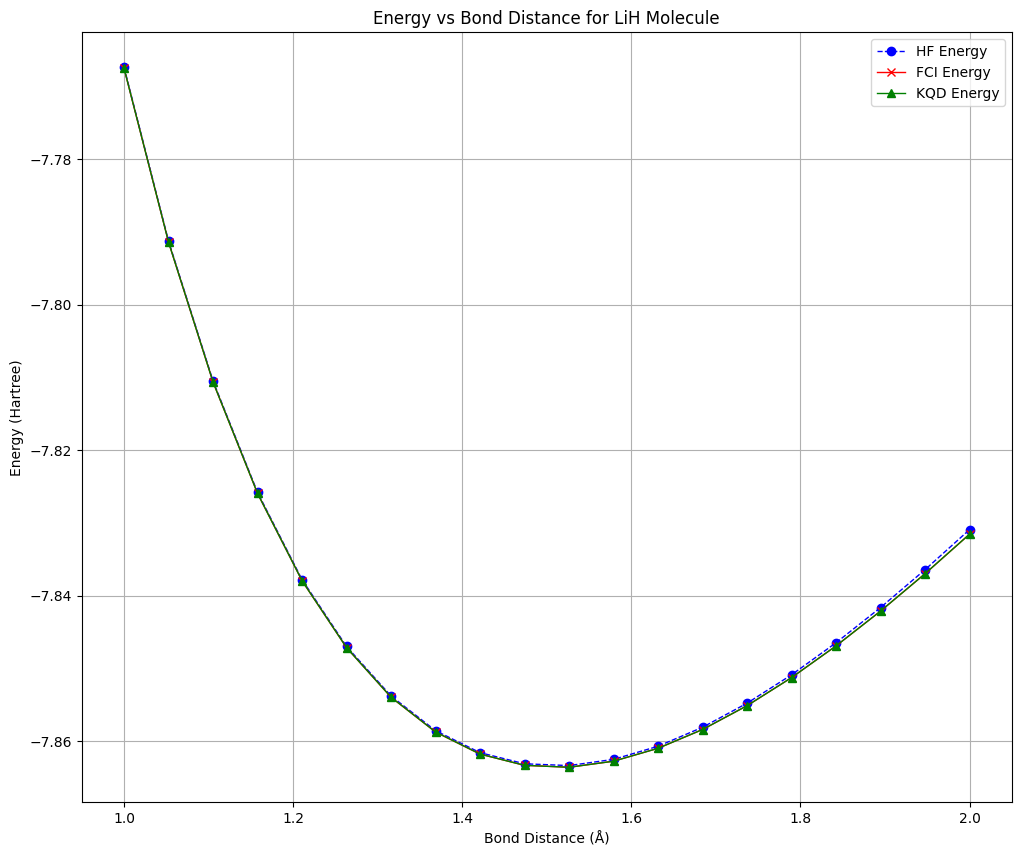

In [174]:
def plot_energies(atom1="Li", atom2="H", distances=np.linspace(1.0, 2.0, 20), basis="sto3g"):
    """Plot HF and FCI energies as a function of bond distance."""
    hf_energies = []
    fci_energies = []
    kqd_energies = []

    for d in distances:
        electronic_structure_problem = electronic_structure_driver(d)

        hf_energy, fci_energy = calculate_exact_energy(electronic_structure_problem)
        kqd_energy = calculate_KQD_energy(electronic_structure_problem)
        hf_energies.append(hf_energy)
        fci_energies.append(fci_energy)
        kqd_energies.append(kqd_energy)


    plt.figure(figsize=(12, 10))
    plt.plot(distances, hf_energies, label="HF Energy", marker="o", linestyle="--", linewidth=1.0, color="blue")
    plt.plot(distances, fci_energies, label="FCI Energy", marker="x", linestyle="-", linewidth = 1.0, color="red")
    plt.plot(distances, kqd_energies, label="KQD Energy", marker="^", linestyle="-", linewidth = 1.0, color="green")
    plt.xlabel("Bond Distance (Å)")
    plt.ylabel("Energy (Hartree)")
    plt.title(f"Energy vs Bond Distance for {atom1}{atom2} Molecule")
    plt.legend()
    plt.grid()
    plt.show()
    return hf_energies, fci_energies, kqd_energies


hf_energy, fci_energy, kqd_energy =  plot_energies()

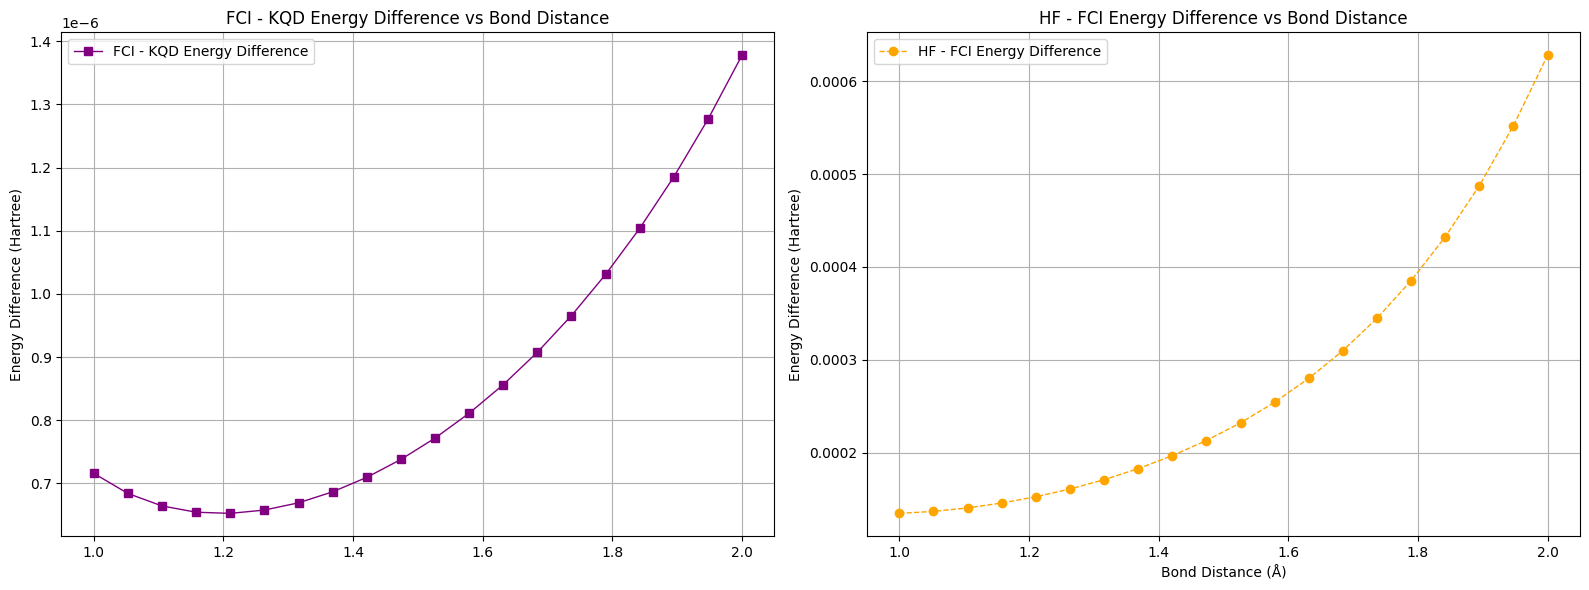

In [175]:
def plot_energy_difference(hf_energy, fci_energy, kqd_energy, distances=np.linspace(1.0, 2.0, 20)):
    # Compute the differences
    fci_kqd_diff = abs(np.array(fci_energy) - np.array(kqd_energy))
    hf_fci_diff = abs(np.array(hf_energy) - np.array(fci_energy))

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

    # First subplot: FCI - KQD energy differences
    axs[0].plot(distances, fci_kqd_diff, label="FCI - KQD Energy Difference", marker="s", linestyle="-", color="purple", linewidth=1)
    axs[0].set_ylabel("Energy Difference (Hartree)")
    axs[0].set_title("FCI - KQD Energy Difference vs Bond Distance")
    axs[0].legend()
    axs[0].grid()

    # Second subplot: HF - FCI energy differences
    axs[1].plot(distances, hf_fci_diff, label="HF - FCI Energy Difference", marker="o", linestyle="--", color="orange", linewidth=1)
    axs[1].set_xlabel("Bond Distance (Å)")
    axs[1].set_ylabel("Energy Difference (Hartree)")
    axs[1].set_title("HF - FCI Energy Difference vs Bond Distance")
    axs[1].legend()
    axs[1].grid()

    # Adjust layout and show
    plt.tight_layout()
    plt.show()


# Call the function
plot_energy_difference(hf_energy, fci_energy, kqd_energy)
